# Deep Learning based Modulation Classification


In [0]:
import os
import numpy as np
import tensorflow as tf
import pandas as pd
import matplotlib.pyplot as plt

## Dataset

In [0]:
train_path = 'data/trainDataLabels.csv'
test_path = 'data/testData.csv'

df_train = pd.read_csv(train_path)
df_test = pd.read_csv(test_path)
# converting a complex number string to np.complex type
x_train = np.array([complex(z.replace('i', 'j')) for z in np.array(df_train.Input)], dtype=np.complex)
y_train = np.array(df_train.Label)
x_test = np.array([complex(z.replace('i', 'j')) for z in np.array(df_test.Input)], dtype=np.complex)

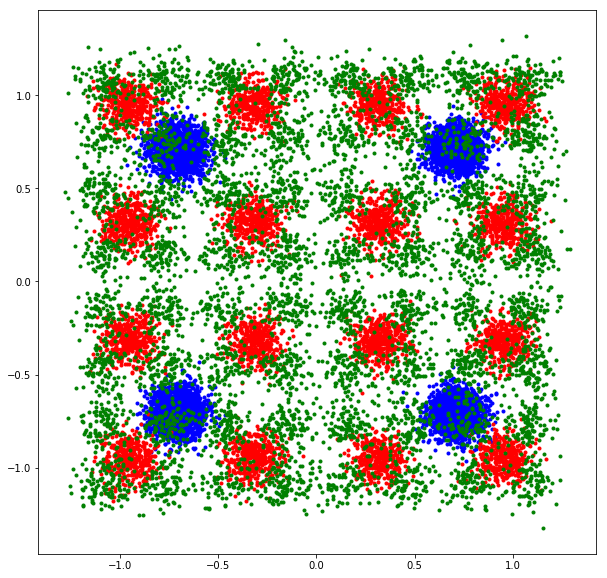

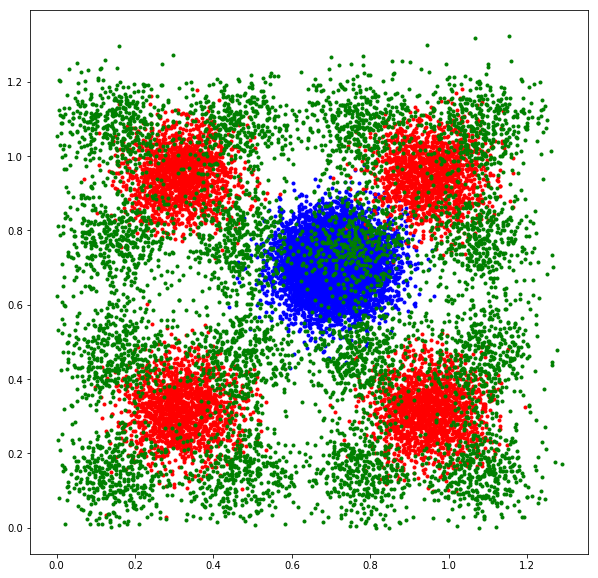

In [8]:
# plotting the datapoints and absolute values of real and imaginary values 
fig = plt.figure(1,figsize=(10,10))
plt.scatter(x_train[np.where(y_train==1)].real, x_train[np.where(y_train==1)].imag, c='b', marker='.')
plt.scatter(x_train[np.where(y_train==2)].real, x_train[np.where(y_train==2)].imag, c='r', marker='.')
plt.scatter(x_train[np.where(y_train==3)].real, x_train[np.where(y_train==3)].imag, c='g', marker='.')
fig = plt.figure(2, figsize=(10,10))
plt.scatter(np.absolute(x_train[np.where(y_train==1)].real), np.absolute(x_train[np.where(y_train==1)].imag), c='b', marker='.')
plt.scatter(np.absolute(x_train[np.where(y_train==2)].real), np.absolute(x_train[np.where(y_train==2)].imag), c='r', marker='.')
plt.scatter(np.absolute(x_train[np.where(y_train==3)].real), np.absolute(x_train[np.where(y_train==3)].imag), c='g', marker='.')
plt.show()

In [0]:
# converting complex numbers to 2D vectors
X_train = np.array([x_train.real, x_train.imag]).T
X_test  = np.array([x_test.real,  x_test.imag]).T
# converting labels to onehot vectors
Y_train = tf.keras.utils.to_categorical(y_train-1)

## The model
I am submitting the model that gave the best performance in kaggle's private leaderboard. The model architectures I have tried for each submission have been mentioned in respective comment in kaggle. 

I used absolute values of the real and imaginary values since the QAM values are symmetric along real and imaginary values and Gaussian Noise is symmetric with respect to origin. We can observe in the second graph above that the data points seem closer to linearly seperable (not completely) than the previous ones. This way, we can reduce the complexity of datapoints. Another argument in support of this idea is, the datapoints are less spread which reduces the complexity in the model - for examples 4-QAM points are in a single cluster in second figure but they are in 4 clusters in the original dataset. 

> Note: Obviously we have to use absolute values of test samples for generating predictions. 

In [0]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
model = Sequential()
model.add(Dense(units=64, activation='relu', input_shape=(2,)))
model.add(Dense(units=64, activation='relu'))
model.add(Dense(units=128, activation='relu'))
model.add(Dense(units=3, activation='softmax'))

In [7]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 64)                192       
_________________________________________________________________
dense_1 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_2 (Dense)              (None, 128)               8320      
_________________________________________________________________
dense_3 (Dense)              (None, 3)                 387       
Total params: 13,059
Trainable params: 13,059
Non-trainable params: 0
_________________________________________________________________


## Training


In [0]:
model.fit(x=np.absolute(X_train), y=np.absolute(Y_train), batch_size=50, epochs=500, validation_split=0.2, verbose=1)

In [0]:
model.save('model.h5')

## Estimates

In [0]:
y_pred = model.predict(np.absolute(X_test))

In [0]:
y_est = np.argmax(y_pred, axis=1) + 1

In [0]:
sample = pd.read_csv('data/sampleSubmission.csv', index_col=0)
sample['Predicted Label'] = y_est

In [0]:
sample.to_csv('Predictions.csv')

In [0]:
# plot the test samples with corresponding predicted lables
fig = plt.figure(3,figsize=(10,10))
plt.scatter(x_test[np.where(y_est==1)].real, x_test[np.where(y_est==1)].imag, c='b', marker='.')
plt.scatter(x_test[np.where(y_est==2)].real, x_test[np.where(y_est==2)].imag, c='r', marker='.')
plt.scatter(x_test[np.where(y_est==3)].real, x_test[np.where(y_est==3)].imag, c='g', marker='.')

## Custom Testing 
Here I have generated noisy 4-QAM, 16-QAM, 64_QAM test set for evaluating my model

0.01


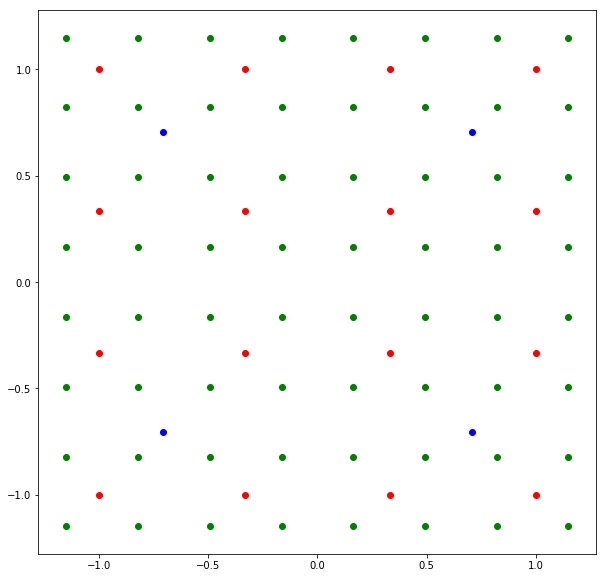

In [12]:
qam4 = (np.arange(-1,2,2)*np.ones((2,2))).T + 1j*np.arange(-1,2,2)
qam16 = (np.arange(-3,4,2)*np.ones((4,4))).T + 1j*np.arange(-3,4,2)
qam64 = (np.arange(-7,8,2)*np.ones((8,8))).T + 1j*np.arange(-7,8,2)
qam4 /= np.abs(qam4).mean()
qam16 /= np.abs(qam16).mean()
qam64 /= np.abs(qam64).mean()
snr_db = 20
snr = 10**(snr_db/10)
N0 = 1/snr
print(N0)
plt.figure(4, figsize=(10,10))
plt.scatter( qam4.real,  qam4.imag, c='b', marker='o')
plt.scatter(qam16.real, qam16.imag, c='r', marker='o')
plt.scatter(qam64.real, qam64.imag, c='g', marker='o')
plt.show()

In [0]:
test_model = tf.keras.models.load_model('model.h5')

def estimate(N): # N*64*3 is the number of datapoints the model is tested on. 
    losses, accuracies = [], []
    labels = np.repeat(np.identity(3), 64, axis=0) # onehot vectors for lables
    for _ in range(N):
        # generate 64 points of each QAM with noise added.  
        noisy_qam4 = np.repeat(qam4.reshape(-1), 16) + np.random.normal(0, (N0/2)**0.5, 64) + 1j*np.random.normal(0, (N0/2)**0.5, 64) 
        noisy_qam16 = np.repeat(qam16.reshape(-1), 4) + np.random.normal(0, (N0/2)**0.5, 64) + 1j*np.random.normal(0, (N0/2)**0.5, 64)
        noisy_qam64 = qam64.reshape(-1) + np.random.normal(0, (N0/2)**0.5, 64) + 1j*np.random.normal(0, (N0/2)**0.5, 64)
        test = np.array(list(noisy_qam4) + list(noisy_qam16) + list(noisy_qam64)) 
        loss, acc = test_model.evaluate(np.absolute(np.array([test.real, test.imag]).T), labels, verbose=0) #evaluate
        losses.append(loss)
        accuracies.append(acc)
    return np.mean(losses), np.mean(accuracies) # mean of all the above gives average loss and accuracy
Loss, Acc = estimate(200)
print(Loss, Acc)